In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Daten laden
file_path = 'vibration_messung_2025-10-15_1704-1737.csv'
df = pd.read_csv(file_path)
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
print("Daten geladen:")
print(df.head())

Daten geladen:
                                    sensor_id  wert
time                                               
2025-10-15 17:04:00.004000+02:00  AnalogValue    67
2025-10-15 17:04:00.024000+02:00  AnalogValue     0
2025-10-15 17:04:00.034000+02:00  AnalogValue     0
2025-10-15 17:04:00.044000+02:00  AnalogValue     0
2025-10-15 17:04:00.054000+02:00  AnalogValue     0


## Feature Engineering

Rohdaten sind oft verrauscht. Wir wenden verschiedene Techniken an, um nützliche Informationen zu extrahieren:

1.  **Rolling Statistics**: Wir berechnen Mittelwert, Standardabweichung, Min und Max über ein Zeitfenster (Glättung).
2.  **Lag Features**: Wir verwenden Werte aus vorherigen Zeitschritten (z. B. t-1), da die Vergangenheit oft die Zukunft beeinflusst.
3.  **Rate of Change**: Wir berechnen die Differenz zwischen aufeinanderfolgenden Werten, um Trends zu erfassen.

Zusätzlich erstellen wir ein **Label** für das überwachte Lernen: Wenn der Mittelwert über 1000 liegt, klassifizieren wir dies als 'Hohe Vibration' (1), andernfalls als 'Normal' (0).

Features und Labels:
                                   mean        std  min    max  mean_lag1  \
time                                                                        
2025-10-15 17:04:00.554000+02:00  44.26  58.683450  0.0  210.0      45.60   
2025-10-15 17:04:00.574000+02:00  44.28  58.668227  0.0  210.0      44.26   
2025-10-15 17:04:00.584000+02:00  45.80  58.481813  0.0  210.0      44.28   
2025-10-15 17:04:00.594000+02:00  45.80  58.481813  0.0  210.0      45.80   
2025-10-15 17:04:00.604000+02:00  47.30  58.244471  0.0  210.0      45.80   

                                   std_lag1  mean_change  label  
time                                                             
2025-10-15 17:04:00.554000+02:00  58.416520        -1.34      0  
2025-10-15 17:04:00.574000+02:00  58.683450         0.02      0  
2025-10-15 17:04:00.584000+02:00  58.668227         1.52      0  
2025-10-15 17:04:00.594000+02:00  58.481813         0.00      0  
2025-10-15 17:04:00.604000+02:00  58.481813

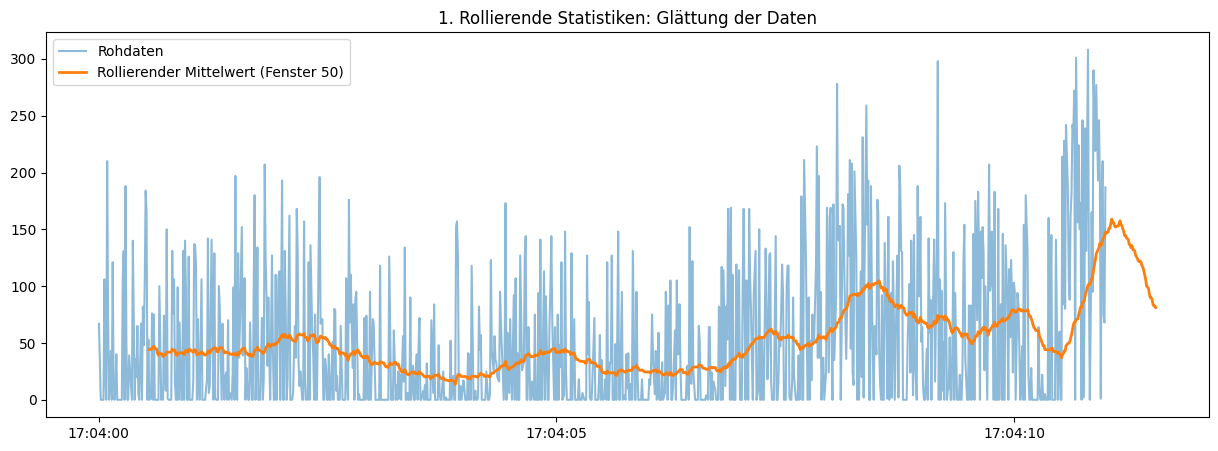

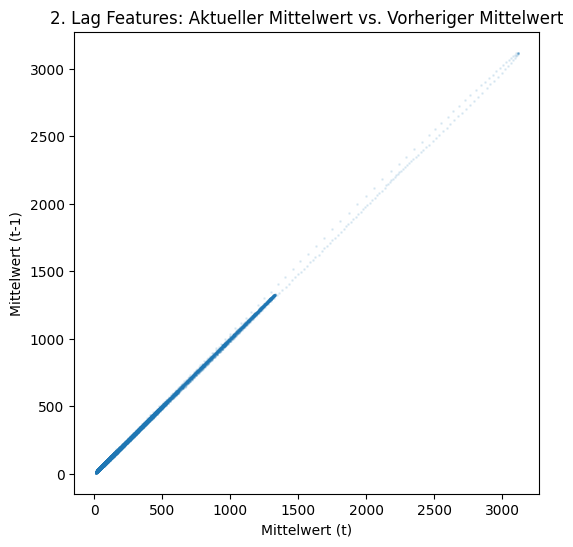

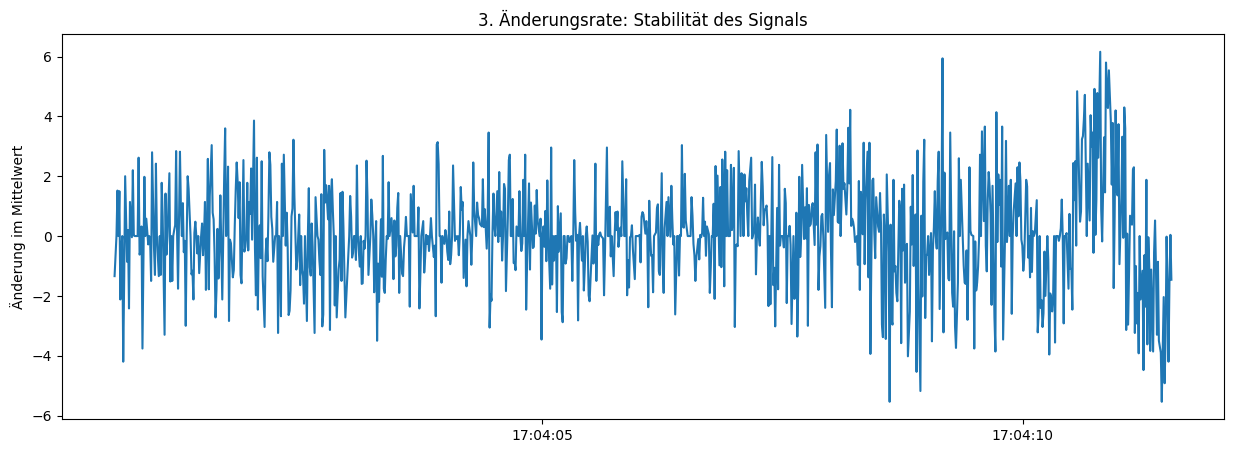

In [5]:
# Berechne rollierende Statistiken (Fenstergröße 50)
window_size = 50
df_features = df[['wert']].rolling(window=window_size).agg(['mean', 'std', 'min', 'max']).dropna()
df_features.columns = df_features.columns.droplevel(0)

# --- NEU: Zusätzliche Features ---
# 1. Lag Features (Werte aus dem vorherigen Schritt)
df_features['mean_lag1'] = df_features['mean'].shift(1)
df_features['std_lag1'] = df_features['std'].shift(1)

# 2. Änderungsrate (Differenz zum vorherigen Schritt)
df_features['mean_change'] = df_features['mean'].diff()



# Entferne NaNs, die durch shift/diff entstanden sind
df_features.dropna(inplace=True)
# --------------------------------

# Erstelle Ziel-Label: "Hohe" Vibration (> 1000) vs "Normal"
# Wir verwenden den Mittelwert des Fensters für das Label
threshold = 1000
df_features['label'] = (df_features['mean'] > threshold).astype(int)

print("Features und Labels:")
print(df_features.head())
print(f"Verteilung der Labels:\n{df_features['label'].value_counts()}")

# --- VISUALISIERUNG ---
# 1. Rollierende Statistiken vs. Rohdaten (Erste 1000 Punkte zur Übersichtlichkeit)
plt.figure(figsize=(15, 5))
plt.plot(df['wert'].iloc[:1000], label='Rohdaten', alpha=0.5)
plt.plot(df_features['mean'].iloc[:1000], label='Rollierender Mittelwert (Fenster 50)', linewidth=2)
plt.title('1. Rollierende Statistiken: Glättung der Daten')
plt.legend()
plt.show()

# 2. Lag Features (Autokorrelation)
plt.figure(figsize=(6, 6))
plt.scatter(df_features['mean'], df_features['mean_lag1'], alpha=0.1, s=1)
plt.title('2. Lag Features: Aktueller Mittelwert vs. Vorheriger Mittelwert')
plt.xlabel('Mittelwert (t)')
plt.ylabel('Mittelwert (t-1)')
plt.show()

# 3. Änderungsrate
plt.figure(figsize=(15, 5))
plt.plot(df_features['mean_change'].iloc[:1000])
plt.title('3. Änderungsrate: Stabilität des Signals')
plt.ylabel('Änderung im Mittelwert')
plt.show()

## Supervised Learning: Klassifikation

Hier trainieren wir Modelle, um zu entscheiden, ob ein Zustand kritisch ist oder nicht.
Wir vergleichen verschiedene Algorithmen:
*   **Decision Tree (Entscheidungsbaum)**: Ein einfaches, interpretierbares Modell, das Daten basierend auf Feature-Werten aufteilt.
*   **Random Forest**: Ein Ensemble aus vielen Entscheidungsbäumen. Sehr robust.

Dabei vergleichen wir auch train-test split und cross validation.

Trainiere Decision Tree...
Decision Tree Genauigkeit: 1.0000

Trainiere Random Forest...
Random Forest Genauigkeit: 0.9996


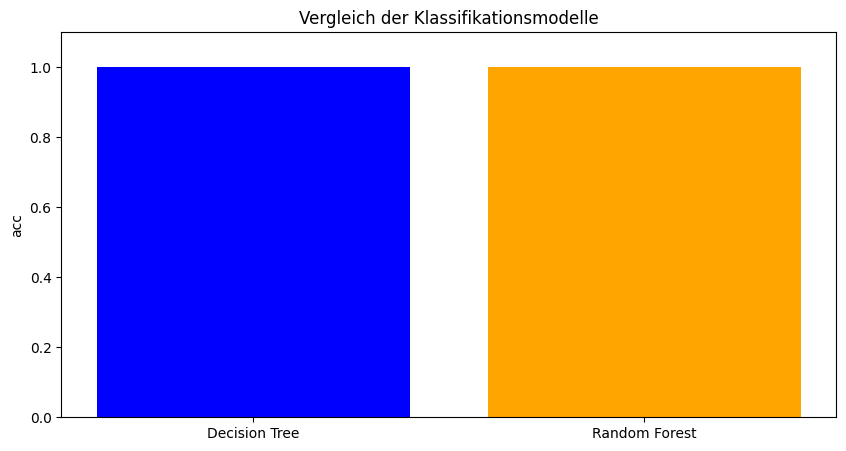

In [7]:
# Bibliotheken importieren
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Daten vorbereiten
X = df_features[['mean', 'std', 'min', 'max', 'mean_lag1', 'std_lag1', 'mean_change']]
y = df_features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Dictionary zum Speichern der Ergebnisse für späteren Vergleich
results = {'acc': {}}

# --- 1. Decision Tree (Beispiel) ---
print("Trainiere Decision Tree...")
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)
results['acc']['Decision Tree'] = acc_dt
print(f"Decision Tree Genauigkeit: {acc_dt:.4f}")

# --- 2. Random Forest (Beispiel) ---
print("\nTrainiere Random Forest...")
rf_model = RandomForestClassifier(n_estimators=2, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
results['acc']['Random Forest'] = acc_rf
print(f"Random Forest Genauigkeit: {acc_rf:.4f}")



# --- Vergleich ---
if results:
    for key in results.keys():
        plt.figure(figsize=(10, 5))
        plt.bar(results[key].keys(), results[key].values(), color=['blue', 'orange', 'green', 'red', 'purple'])
        plt.title('Vergleich der Klassifikationsmodelle')
        plt.ylabel(key)
        plt.ylim(0, 1.1)
        plt.show()
else:
    print("Noch keine Modelle trainiert.")

Trainiere Decision Tree...
Decision Tree Genauigkeit: 1.0000

Trainiere Random Forest...
Random Forest Genauigkeit: 0.9999


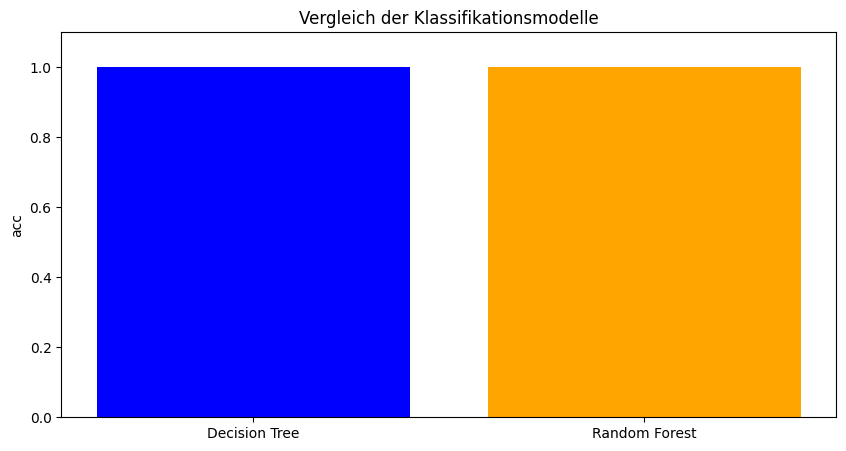

In [13]:
# Bibliotheken importieren
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.model_selection import StratifiedKFold
# Daten vorbereiten
X = df_features[['mean', 'std', 'min', 'max', 'mean_lag1', 'std_lag1', 'mean_change']]
y = df_features['label']

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary zum Speichern der Ergebnisse für späteren Vergleich
results = {'acc': {}}

# --- 1. Decision Tree (Beispiel) ---
print("Trainiere Decision Tree...")
accs = []
dt_model = DecisionTreeClassifier(random_state=42)
for train, test in kfold.split(X,y):
      
    X_train = X.iloc[train]
    y_train = y.iloc[train]
    X_test = X.iloc[test]
    y_test = y.iloc[test]
    dt_model.fit(X_train, y_train)
    y_pred_dt = dt_model.predict(X_test)
    acc_dt = accuracy_score(y_test, y_pred_dt)
    accs.append(acc_dt)
results['acc']['Decision Tree'] = np.mean(accs)
print(f"Decision Tree Genauigkeit: {np.mean(accs):.4f}")


accs = []
# --- 2. Random Forest (Beispiel) ---
print("\nTrainiere Random Forest...")
rf_model = RandomForestClassifier(n_estimators=2, random_state=42)
accs_rf = []
for train, test in kfold.split(X, y):
    X_train = X.iloc[train]
    y_train = y.iloc[train]
    X_test = X.iloc[test]
    y_test = y.iloc[test]
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    acc_rf = accuracy_score(y_test, y_pred_rf)
    accs_rf.append(acc_rf)
results['acc']['Random Forest'] = np.mean(accs_rf)
print(f"Random Forest Genauigkeit: {np.mean(accs_rf):.4f}")



# --- Vergleich ---
if results:
    for key in results.keys():
        plt.figure(figsize=(10, 5))
        plt.bar(results[key].keys(), results[key].values(), color=['blue', 'orange', 'green', 'red', 'purple'])
        plt.title('Vergleich der Klassifikationsmodelle')
        plt.ylabel(key)
        plt.ylim(0, 1.1)
        plt.show()
else:
    print("Noch keine Modelle trainiert.")

## Supervised Learning: Regression

Bei der Regression wollen wir keinen Zustand (Klasse) vorhersagen, sondern einen **konkreten numerischen Wert**.
Aufgabe: Wir versuchen, den **Mittelwert** basierend auf den anderen Features ('std', 'min', 'max') vorherzusagen.

Modelle:
*   **Linear Regression**: Sucht nach einem linearen Zusammenhang.
*   **Decision Tree Regressor**: Ein Entscheidungsbaum für numerische Werte.
*   **Random Forest Regressor**: Ein Ensemble von Entscheidungsbäumen für kontinuierliche Werte.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

# 1. Daten zuerst bereinigen
cols = ['std', 'min', 'max', 'mean', 'mean_lag1', 'std_lag1', 'mean_change']
df_clean = df_features[cols].replace([np.inf, -np.inf], np.nan).dropna()

X_reg = df_clean[['std', 'min', 'max', 'mean_lag1', 'std_lag1', 'mean_change']]
y_reg = df_clean['mean']

# 2. Aufteilen
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42, shuffle=False
)

print(f"Starte Training mit {len(X_train_r)} Beispielen...")

# --- 1. Decision Tree Regressor (Beispiel) ---
print("\nTrainiere Decision Tree Regressor...")
dt_reg = DecisionTreeRegressor(random_state=42, max_depth=10)
dt_reg.fit(X_train_r, y_train_r)
y_pred_dt = dt_reg.predict(X_test_r)

mse_dt = mean_squared_error(y_test_r, y_pred_dt)
r2_dt = r2_score(y_test_r, y_pred_dt)
print(f"Decision Tree - MSE: {mse_dt:.2f}, R2: {r2_dt:.4f}")



Starte Training mit 128652 Beispielen...

Trainiere Decision Tree Regressor...
Decision Tree - MSE: 3.97, R2: 0.9999

Trainiere Linear Regression (TODO)...

Trainiere Random Forest Regressor (TODO)...


## Unsupervised Learning: K-Means Clustering

Hier haben wir keine Labels. Der Algorithmus versucht selbstständig, Gruppen (Cluster) in den Daten zu finden.

In [ ]:
# Daten skalieren
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Trainiere K-Means (wir erwarten 2 Cluster: Normal und Hoch)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Visualisierung
plt.figure(figsize=(15, 5))
plt.scatter(df_features.index, df_features['mean'], c=clusters, cmap='viridis', marker='.')
plt.title('K-Means Clustering der Vibrationsdaten')
plt.xlabel('Zeit')
plt.ylabel('Mittlere Vibration')
plt.show()

<IPython.core.display.Javascript object>

## Deep Learning Showcase

**Hinweis**: Für strukturierte Daten (Tabellen) wie diese sind klassische ML-Modelle (wie Random Forest oder Gradient Boosting) oft **besser, schneller und einfacher** zu trainieren als Deep Learning.
Deep Learning glänzt besonders bei unstrukturierten Daten wie Bildern, Audio oder komplexem Text.

Hier zeigen wir dennoch kurz, wie man ein einfaches neuronales Netz (MLP) mit Keras erstellt.

In [ ]:
# Daten skalieren (MinMax oft besser für NN)
scaler_nn = MinMaxScaler()
X_train_nn = scaler_nn.fit_transform(X_train)
X_test_nn = scaler_nn.transform(X_test)

# Modell erstellen
mlp_model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training
history_mlp = mlp_model.fit(X_train_nn, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluierung
loss, accuracy = mlp_model.evaluate(X_test_nn, y_test)
print(f"MLP Test Genauigkeit: {accuracy:.4f}")

y_pred = [mlp_model.predict(i) for i in X_test_nn]

acc = accuracy_score(y_pred=y_pred, y_true=y_test)

c:\Users\j.ihl\AppData\Local\anaconda3\envs\KI-Trainieren\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
3217/3217 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9995 - loss: 0.0189 - val_accuracy: 0.9980 - val_loss: 0.0059
Epoch 2/5
3217/3217 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9998 - loss: 4.2921e-04 - val_accuracy: 0.9989 - val_loss: 0.0042
Epoch 3/5
3217/3217 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9999 - loss: 3.1225e-04 - val_accuracy: 0.9984 - val_loss: 0.0039
Epoch 4/5
3217/3217 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9999 - loss: 2.4848e-04 - val_accuracy: 0.9990 - val_loss: 0.0036
Epoch 5/5
 225/3217 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9998 - loss: 3.9079e-04

KeyboardInterrupt: 